# Facial images preprocessing - blog version

In this notebook we'll apply some OpenCV functions in order to crop faces in images. First part contains easy examples step by step. Second part joins the desired operations for batch processing an entire image set for further Convolutional Neural Network training.

## Imports

In [0]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

from fastai.vision import *

np.random.seed(42)

In [0]:
%%capture
from notebook import notebookapp
server = list(notebookapp.list_running_servers())[0]

if server['hostname'] == 'localhost':
    # Local environment
    from cv2 import imshow as cv2_imshow
    %reload_ext autoreload
    %autoreload 2
    %matplotlib inline
else:
    # Cloud
    from google.colab.patches import cv2_imshow as cv2_imshow

In [0]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.54
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run th

## Single Image Processing

### Image loading

To load an image we'll use the `imread()` function, specifying the path to the file and the color type (`IMREAD_COLOR` for normal color images)

In [0]:
! mkdir img
! mv *.jpg img/

mkdir: cannot create directory ‘img’: File exists


In [0]:
face_img = cv2.imread('img/neno.jpg', cv2.IMREAD_COLOR)

In [0]:
type(face_img), face_img.shape

(numpy.ndarray, (288, 300, 3))

If you type `type(img)` you'll see the dimensions as (*height*, *weight*, *channels*). Our color image have **3 channels**: blue, green, red (in this order within OpenCV).


To show the image we use the `imshow()` function (in Colab there's a patch for it, called `cv2_imshow`).

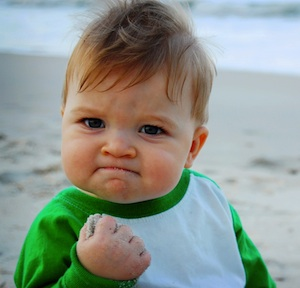

In [0]:
cv2_imshow(face_img)

We can plot a single color channel:



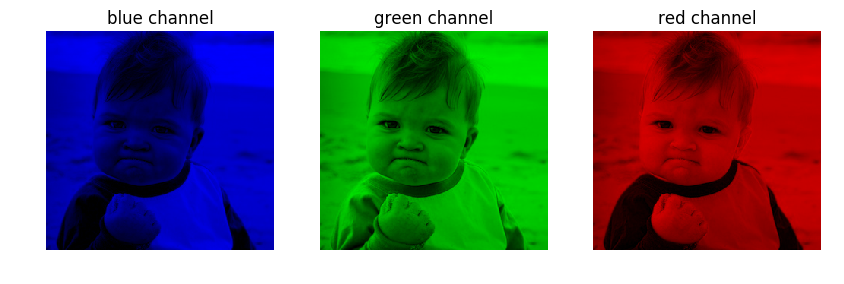

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=100);
img_b = face_img.copy(); img_b[:,:,1] = 0; img_b[:,:,2] = 0
img_g = face_img.copy(); img_g[:,:,0] = 0; img_g[:,:,2] = 0
img_r = face_img.copy(); img_r[:,:,0] = 0; img_r[:,:,1] = 0
images = {'blue channel': img_b, 
          'green channel': img_g, 
          'red channel': img_r}

i=0
for k, v in images.items():
    ax[i].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    ax[i].set_title(k)
    ax[i].axis('off')
    i += 1

### Greyscale version

In order to avoid color *distractions* in facial image classification it could be a good idea to use black and white versions (or maybe not! you can always try both). We only have to specify that in the image loading function using `IMREAD_GRAYSCALE`.

In [0]:
face_img = cv2.imread('img/neno.jpg', cv2.IMREAD_GRAYSCALE)

In [0]:
type(face_img), face_img.shape

(numpy.ndarray, (288, 300))

Now our image has a single channel!

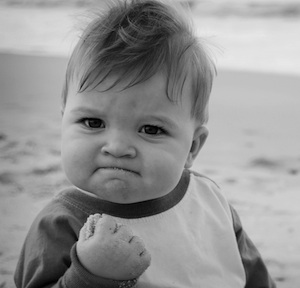

In [0]:
cv2_imshow(face_img)

### Face detection

We'd like to do face detection in order to validate and straighten images. We'll use the [Haar Feature-based Cascade Classifier for Object Detection](https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html) included in OpenCV for this.

First we choose the pre-trained classifiers for facial and eyes detection. Below is a list of the XML files containing them.

1) For **face detection**, OpenCV offers these ones (from the a priori more relaxed to the more strict):
* haarcascade_frontalface_default.xml
* haarcascade_frontalface_alt2.xml
* haarcascade_frontalface_alt.xml
* haarcascade_frontalface_alt_tree.xml

2) For **eyes detection**, we can choose between two:
* haarcascade_eye_tree_eyeglasses.xml (works well with glasses!)
* haarcascade_eye.xml

We cant test several combinations. Have in mind that there isn't one being the best for all images.


We load the pre-trained classifier:

In [0]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
# eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')

We load the sample image:

In [0]:
# face_img = cv2.imread('img/gollum.jpg', cv2.IMREAD_COLOR)
# face_img = cv2.imread('img/sandra.jpg', cv2.IMREAD_COLOR)
# face_img = cv2.imread('img/powers.jpg', cv2.IMREAD_COLOR)
face_img = cv2.imread('img/neno.jpg', cv2.IMREAD_COLOR)

face_orig = face_img.copy()

We first try to detect face(s) in our photo:

In [0]:
face_detect = face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=5)
print(f'Faces found: {len(face_detect)}')
face_detect

Faces found: 1


array([[ 46,  71, 140, 140]], dtype=int32)

Now we try to detect the eyes:

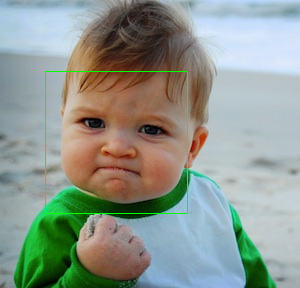

In [0]:
eye_pos = []

if len(face_detect):
    # face rectangle
    (x, y, w, h) = face_detect[0]
    cv2.rectangle(face_img, (x, y), (x+w, y+h), (0, 255, 0), 1);
    # eyes
    eyes = eyes_cascade.detectMultiScale(face_img[y:y+h, x:x+w])
    for (ex, ey, ew, eh) in eyes:
        eye_pos.append(x+ex+ew/2)
        eye_pos.append(y+ey+eh/2)
        cv2.rectangle(face_img, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (255, 255, 255), 1)

#     plt.figure(figsize=(4,4), dpi=66)
#     plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
    cv2_imshow(face_img)

In our case, if we don't detect both eyes maybe we should discard the sample, because we couldn't know if the face is straight or not.

### Face alignment

We can straighten a face if we calculate the angle between both eyes:

In [0]:
eye_pos

[91.5, 122.5, 151.0, 131.0]

In [0]:
angle = math.degrees(math.atan2(eye_pos[3]-eye_pos[1], eye_pos[2]-eye_pos[0]))
angle

8.13010235415598

We rotate the picture so both eyes are aligned:

In [0]:
rows,cols = face_img.shape[:2]
M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
face_rot = cv2.warpAffine(face_orig, M, (cols,rows))

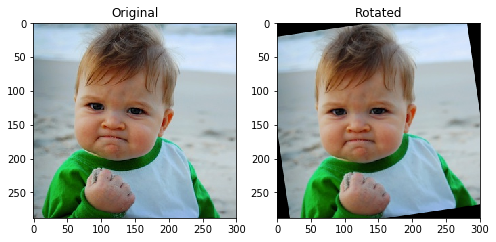

In [0]:
plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(cv2.cvtColor(face_orig, cv2.COLOR_BGR2RGB)), plt.title('Original');
plt.subplot(122), plt.imshow(cv2.cvtColor(face_rot, cv2.COLOR_BGR2RGB)), plt.title('Rotated');

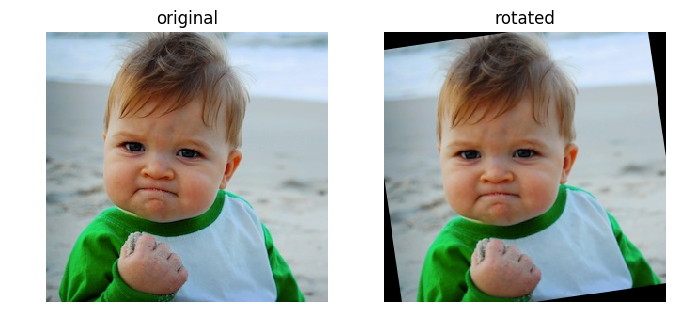

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=100);
images = {'original': face_orig,
                 'rotated': face_rot}

i = 0
for k, v in images.items():
    ax[i].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    ax[i].set_title(k)
    ax[i].axis('off')
    i += 1

### Face cropping

In order to help our neural network to classify faces, is nice to get rid of external distracting info, like the background, clothes, or accesories. As we're classifying faces by gender and nationality, the cropped rectangle could be different for each purpose. For gender it could be a good idea to get a larger area, as opposite to the case of nationalities, (well... it depends on the number of classes we take into account... we can mix men and women, or not).

First thing we need is getting the face rectangle again (as we rotated the image, the rectangle rotated too):

In [0]:
face_detect = face_cascade.detectMultiScale(face_rot, scaleFactor=1.1, minNeighbors=5)
print(f'Faces found: {len(face_detect)}')

Faces found: 1


Here comes the interesting part. We'll use a padding to enlarge the rectangle as much as we want. Finally, we crop the image using those measures and save the result to a file:

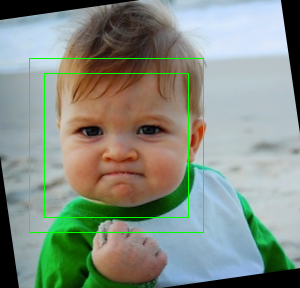

In [0]:
if len(face_detect):
    # face rectangle
    (x, y, w, h) = face_detect[0]

    # padding
    p = 0# math.ceil(h/10)

    cv2.rectangle(face_rot, (x-p, y-p), (x+w+p, y+h+p), (0, 255, 0), 1);

    cv2_imshow(face_rot)

    # cropping (add 1 to the origin to avoid the rectangle)
    cv2.imwrite('crop.jpg', face_rot[y-p+1:y+h+p, x-p+1:x+w+p])

In [0]:
face_crop = cv2.imread('crop.jpg', cv2.IMREAD_COLOR)
type(face_crop), face_crop.shape

(numpy.ndarray, (143, 143, 3))

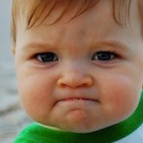

In [0]:
cv2_imshow(face_crop)

### Image resizing

Neural networks need that all input images have the same size in a training stage (you can change sizes in different stages). We can resize them on the fly, but it could be a bad idea since it would mean a lot of resizings for each file in training time. So if we have a lot of pictures is better to do it before.

Here, we test different downscaling and upscaling methods included in OpenCV:

In [0]:
# help(cv2.resize)

In [0]:
def cv2_resize(original, size, interpolation):
    return cv2.resize(original, (size, size), interpolation=interpolation)

#### Downscaling

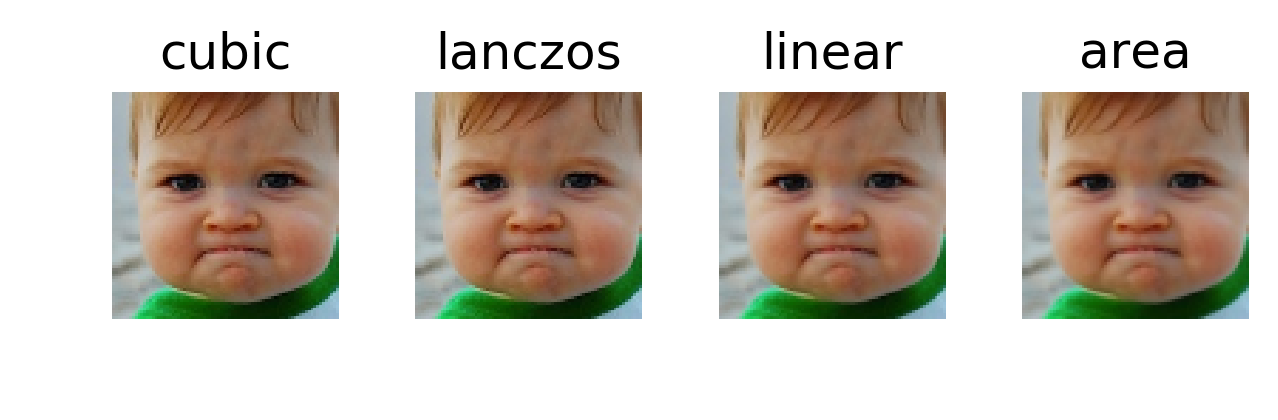

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(5, 1), dpi=300);
resized_images = {'cubic': cv2_resize(face_crop, 80, cv2.INTER_CUBIC),
                 'lanczos': cv2_resize(face_crop, 80, cv2.INTER_LANCZOS4),
                 'linear': cv2_resize(face_crop, 80, cv2.INTER_LINEAR),
                 'area': cv2_resize(face_crop, 80, cv2.INTER_AREA)}

i = 0
for k, v in resized_images.items():
    ax[i].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    ax[i].set_title(k)
    ax[i].axis('off')
    i += 1

#### Upscaling

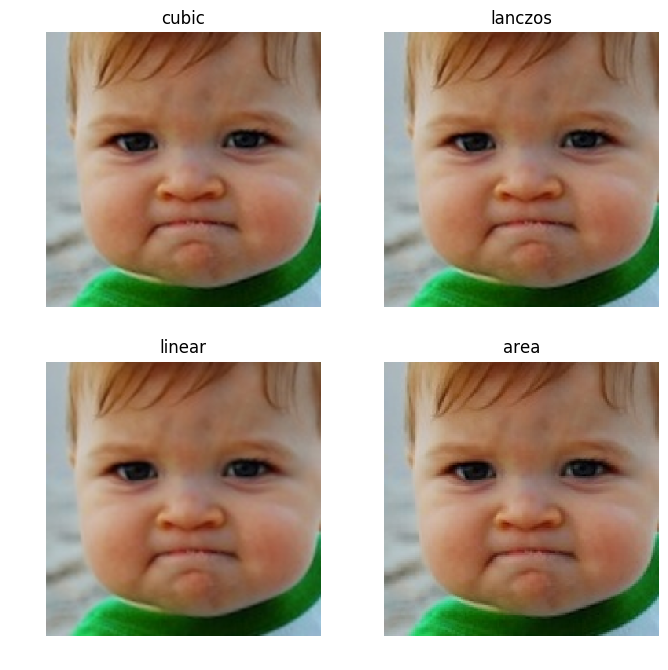

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=100);
resized_images = {'cubic': cv2_resize(face_crop, 350, cv2.INTER_CUBIC),
                 'lanczos': cv2_resize(face_crop, 350, cv2.INTER_LANCZOS4),
                 'linear': cv2_resize(face_crop, 350, cv2.INTER_LINEAR),
                 'area': cv2_resize(face_crop, 350, cv2.INTER_AREA)}

i = 0
t = [(0,0),(0,1),(1,0),(1,1)]
for k, v in resized_images.items():
    ax[t[i]].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    ax[t[i]].set_title(k)
    ax[t[i]].axis('off')
    i += 1

Slight differences appreciated between them. For color we'll use one of the first two. For greyscale we might use the linear method, which seems smoother with less noise, and is recommended for black and white.

### Normalization

We can use the [`normalize()`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd) function to apply visual normalization in order to fix very dark/light pictures. We can even fix low contrast.

NOTE: If we don't set `vmin` and `vmax` parameters in `imshow()`, we get the normalized visualization of the image!

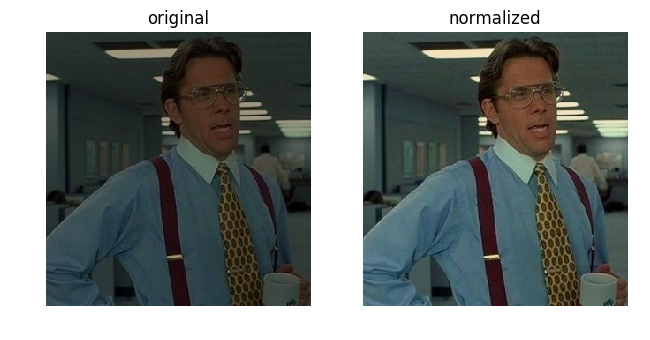

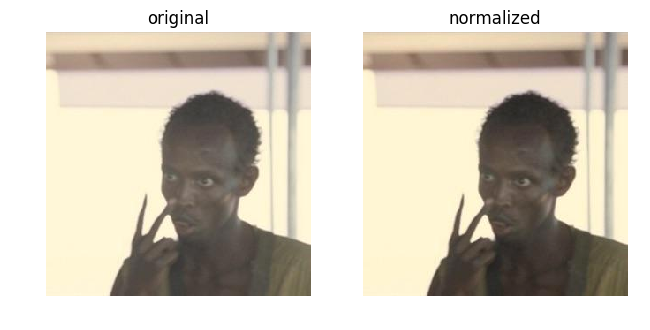

In [0]:
face_imgs = [cv2.imread('img/great.jpg', cv2.IMREAD_COLOR), # dark
             cv2.imread('img/look.jpg', cv2.IMREAD_COLOR)] # low contrast

for face_img in face_imgs:
    norm_img = np.zeros((200, 200))
    norm_img = cv2.normalize(face_img, norm_img, 0, 255, cv2.NORM_MINMAX)
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 4), dpi=100);
    images = {'original': face_img, 'normalized': norm_img}

    i = 0
    for k, v in images.items():
        ax[i].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)
        ax[i].set_title(k)
        ax[i].axis('off')
        i += 1

NOTE: When using images as input for Convolutional Neural Networks, there is no need to apply a normalization of this kind (seems good to our eyes, not to *theirs*). In [practice](http://cs231n.github.io/neural-networks-2/#datapre) we'll do a proper normalization depending on our architecture (if we use transfer learning, best approach is using the pretrained model stats).

## Batch Processing

In this section we apply every interesting piece we saw before in batch mode :)

### Batch Rotating and Cropping

In [0]:
img_path = Path('data/faces')
crop_path = Path('data/face_crops')
! rm -r {crop_path}
crop_path.mkdir(parents=True, exist_ok=False)
crop_path

We use all available classifiers for face/eyes detection, because we don't want to discard valid samples. 

In a previous test we proved that's the better option:


- alt + eye: 1233
- alt2 + eye: 1259
- alt_tree + eye: 572
- default + eye: 1221


- alt2 + eyeglasses: 812
- alt + eyeglasses: 853
- default + eyeglasses: 822


- combined: 1405

In [0]:
face_cascades = [cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt_tree.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')]
eyes_cascades = [cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')]

We write functions this time :)

In [0]:
def detect_face(face_img):
    for face_cascade in face_cascades:
        face = face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=5)
        if len(face) == 1:
            return face[0]

def detect_eyes(face_rectangle):
    for eyes_cascade in eyes_cascades:
        eyes = eyes_cascade.detectMultiScale(face_rectangle)
        if len(eyes) == 2:
            return eyes

In [0]:
def rotate_image(face_img, eyes):
    
    eye_pos = []
    for (ex, ey, ew, eh) in eyes:
        eye_pos.append(x+ex+ew/2)
        eye_pos.append(y+ey+eh/2)
                
    if eye_pos[0] < eye_pos[2]:
        angle = math.degrees(math.atan2(eye_pos[3]-eye_pos[1], eye_pos[2]-eye_pos[0]))
    else:
        angle = math.degrees(math.atan2(eye_pos[1]-eye_pos[3], eye_pos[0]-eye_pos[2]))
    
    # angle threshold
    if abs(angle) > 40:
        return
    
    rows, cols = face_img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    
    return cv2.warpAffine(face_img, M, (cols,rows))

In [0]:
def process_image(f, dest_folder):
    
    # image loading
    face_img = cv2.imread(str(f), cv2.IMREAD_COLOR)

    # face detection
    face = detect_face(face_img)
    if face is None:
        return
    
    (x, y, w, h) = face
    
    # eyes detection
    eyes = detect_eyes(face_img[y:y+h, x:x+w])
    if eyes is None:
        return
    
    # rotation
    face_rot = rotate_image(face_img, eyes)
    if face_rot is None:
        return
    
    # face detection again for cropping
    face = detect_face(face_rot)
    if face is None:
        return
    
    (x, y, w, h) = face
    
    # padding (using this for gender differentiation could be good)
    p = 0 #math.ceil(h/10)
    
    # cropping
    face_crop = face_rot[y-p+1:y+h+p, x-p+1:x+w+p]
    
    # file saving, with a size threshold
    if face_crop.shape[0] > 66:
        cv2.imwrite(str(dest_folder/f.name), face_crop)

Execute the batch process that get the face crops:

In [0]:
nationalities = ['cn', 'jp', 'kr']
genders = ['m', 'w']

for n in nationalities:
    for g in genders:
        folder = crop_path/n/g
        folder.mkdir(parents=True, exist_ok=True)
        fnames = get_image_files(img_path/n/g, recurse=True)
        
        for f in fnames:
            process_image(f, crop_path/n/g)
        
        #verify_images(crop_path/n/g, delete=True)

Zip the image for backup:

In [0]:
! zip -r face_crops.zip data/face_crops

### Batch Resizing

We use Pillow for resizing, since it seems to be faster:

In [0]:
# # Uncomment this if you upload the crops in a zip file
# ! rm -r data/face_crops
# ! unzip face_crops.zip

In [0]:
! rm -r {path_80}
! rm -r {path_112}
! rm -r {path_140}

This code is partly borrowed from **fastai** docs:

In [0]:
path_80 = Path('data/face_crops_80')
path_112 = Path('data/face_crops_112')
path_140 = Path('data/face_crops_140')

il = ImageList.from_folder(crop_path)

def resize_one(fn, i, path, size):
    try:
        dest = path/fn.relative_to(crop_path)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, size, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.ANTIALIAS).convert('RGB')
        img.save(dest, quality=90)#90
    except:
        pass

# create smaller image sets the first time this nb is run
sets = [(path_80, 80), (path_112, 112), (path_140, 140)]
for p, size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

Zip the images for backup:

In [0]:
! zip -r face_crops_resized.zip data/face_crops_*